<a href="https://colab.research.google.com/github/poduguvenu/Supervised-Machine-Learning/blob/main/avocado_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avocado Price Prediction

The objective of the analysis is to predict the prices of the Avocados

## Dataset
We will be working with the dataset from Hass Avocado Board website.
The dataset [Avocado Prices ](https://www.kaggle.com/neuromusic/avocado-prices) has been downloaded from `Kaggle Datasets`

The dataset contains the historical data on avocado prices and sales volume in multiple US markets

### Brief discription about few columns from the dataset:
Date - The date of the observation

* `Date` - The date of the observation
* `AveragePrice` - the average price of a single avocado
* `type` - conventional or organic
* `year` - the year
* `Region` - the city or region of the observation
* `Total Volume` - Total number of avocados sold
* `4046` - Total number of avocados with PLU 4046 sold
* `4225` - Total number of avocados with PLU 4225 sold
* `4770` - Total number of avocados with PLU 4770 sold


## Notebook Contents


* Import the data with Pandas, remove any null values, and one hot encode categoricals. Either Scikit-learn's feature encoders or Pandas get_dummies method can be used.
* Split the data into train and test sets.
* Log transform skewed features.
* Scaling can be attempted, although it can be interesting to see how well regularization works without scaling features.
* Write a function `rmse` that takes in truth and prediction values and returns the root-mean-squared error. Use sklearn's mean_squared_error.
* Fit a regular (non-cross validated) Ridge model to a range of 
α values and plot the RMSE using the cross validated error function you created above.
* Fit a Lasso model using cross validation and determine the optimum value for 
α and the RMSE using the function created above.
* Repeat this with the Elastic net model.
* Compare the results via table or plot.


# Importing Required Libraries

In [100]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

Populating the interactive namespace from numpy and matplotlib


# Import the Data


In [101]:
filepath = 'avocado.csv'
data = pd.read_csv(filepath)

# Exploring the Data

In [102]:
data.shape

(18249, 14)

In [103]:
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


> From above we can say that the dataset if free of null values. We can also check this with the following code

In [105]:
data.isnull().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

> Checking the statistical description of the data

In [106]:
data.describe()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


> Let's check the `datatypes`

In [107]:
data.dtypes

Unnamed: 0        int64
Date             object
AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
year              int64
region           object
dtype: object

> Lets check the `value_counts` for the data types

In [108]:
data.dtypes.value_counts()

float64    9
object     3
int64      2
dtype: int64

> Let's verify the distribution of the `target` feature `AveragePrice`

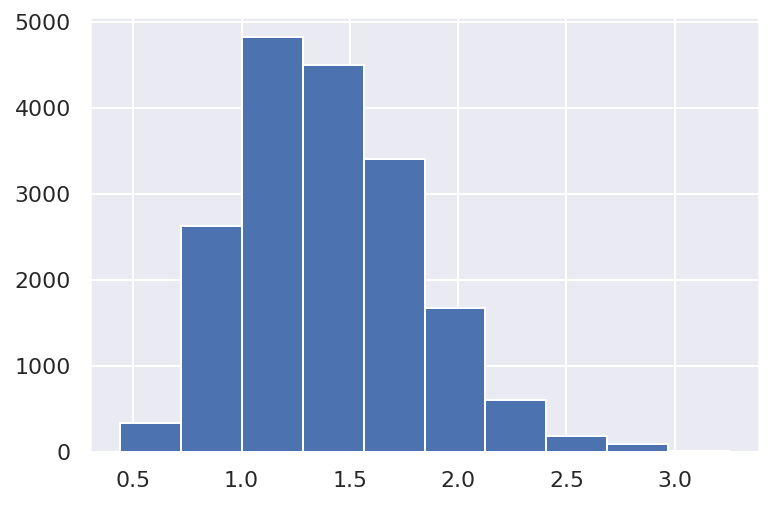

In [109]:
data['AveragePrice'].hist()

> From above figure we can say that the target feature `AveragePrice` is right skewed

Let's verify the number of unique values that are present in the `object` data types

In [110]:
data.select_dtypes('object').nunique()

Date      169
type        2
region     54
dtype: int64

> From the above result we can say that the `Date` feature must be converted to `Datetime` format

> Let's explore `region` feature which has `54` unique labels


In [111]:
data['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [112]:
data.region.value_counts()

Nashville              338
Albany                 338
RichmondNorfolk        338
NorthernNewEngland     338
Boise                  338
LosAngeles             338
West                   338
MiamiFtLauderdale      338
Denver                 338
Philadelphia           338
Boston                 338
Plains                 338
SanDiego               338
Detroit                338
HartfordSpringfield    338
Northeast              338
Orlando                338
Roanoke                338
GrandRapids            338
Syracuse               338
Charlotte              338
Portland               338
SanFrancisco           338
BaltimoreWashington    338
NewYork                338
Tampa                  338
StLouis                338
Sacramento             338
NewOrleansMobile       338
Columbus               338
LasVegas               338
Midsouth               338
Louisville             338
DallasFtWorth          338
Houston                338
Spokane                338
SouthCentral           338
H

# Feature Engineering
> Before starting our analysis let's make a copy of our dataset

In [157]:
df = data.copy()

In [158]:
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


> ## First let's convert our `Date` feature from `object` to `Datetime` format

In [159]:
df['Date'] = pd.to_datetime(df['Date'])
df.Date[:10]

0   2015-12-27
1   2015-12-20
2   2015-12-13
3   2015-12-06
4   2015-11-29
5   2015-11-22
6   2015-11-15
7   2015-11-08
8   2015-11-01
9   2015-10-25
Name: Date, dtype: datetime64[ns]

> ### Create a new feature `season` from the `Date` feature

In [160]:
df['Month'] = df['Date'].dt.month
cond_list = [
                df['Month'].between(3, 5, inclusive = True),
                df['Month'].between(6, 8, inclusive = True),
                df['Month'].between(9, 11, inclusive = True),
                df['Month'].between(12, 12, inclusive = True),
                df['Month'].between(1, 2, inclusive = True)
]

# spring = 0, summer = 1, fall = 2, winter = 3
labels = ['spring', 'summer', 'fall', 'winter', 'winter']

df['season'] = np.select(cond_list, labels)
df = df.drop('Month', axis = 1)

In [161]:
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,season
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,winter
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,winter
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,winter
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,winter
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,fall


In [162]:
df.dtypes

Unnamed: 0               int64
Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
season                  object
dtype: object

> ## Romove the `Unnamed: 0` feature which doesn't have information about and also `Date` feature

In [163]:
df.drop(['Unnamed: 0', 'Date'], axis = 1, inplace = True)

In [164]:
df.columns

Index(['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'region',
       'season'],
      dtype='object')

> # One-hot encoding for dummy variables

In [165]:
# Get a Pd.Series consisting of all the string categoricals

ohc_cols = df.dtypes[df.dtypes == np.object]
ohc_cols = ohc_cols.index.tolist()

df[ohc_cols].head()

,type,region,season
0,conventional,Albany,winter
1,conventional,Albany,winter
2,conventional,Albany,winter
3,conventional,Albany,winter
4,conventional,Albany,fall


> ### Here we're going to use `get_dummies()` function from `pandas` to One-hot endode the categorical features

In [166]:
df = pd.get_dummies(df, columns = ohc_cols, drop_first = True)
df.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year,type_organic,region_Atlanta,region_BaltimoreWashington,region_Boise,region_Boston,region_BuffaloRochester,region_California,region_Charlotte,region_Chicago,region_CincinnatiDayton,region_Columbus,region_DallasFtWorth,region_Denver,region_Detroit,region_GrandRapids,region_GreatLakes,region_HarrisburgScranton,region_HartfordSpringfield,region_Houston,region_Indianapolis,region_Jacksonville,region_LasVegas,region_LosAngeles,region_Louisville,region_MiamiFtLauderdale,region_Midsouth,region_Nashville,region_NewOrleansMobile,region_NewYork,region_Northeast,region_NorthernNewEngland,region_Orlando,region_Philadelphia,region_PhoenixTucson,region_Pittsburgh,region_Plains,region_Portland,region_RaleighGreensboro,region_RichmondNorfolk,region_Roanoke,region_Sacramento,region_SanDiego,region_SanFrancisco,region_Seattle,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico,season_spring,season_summer,season_winter
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [167]:
df.shape

(18249, 67)

> # Split the Data into Training and Test sets

In [168]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.3, random_state = 42)

In [169]:
train.shape

(12774, 67)

In [170]:
test.shape

(5475, 67)

> # Log Transforming Skewed Features
There are a number of columns that are skewed - a log transformation can be applied to them. 

In [171]:
df.select_dtypes('float').head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0


> ### Create a list of float colums to check for skewing

In [172]:
float_cols = df.select_dtypes('float').columns

# define a limit above which we will log transform
skew_limit = 0.75
skew_vals = train[float_cols].skew()

In [173]:
# Showing the skewed columns
skew_cols = (skew_vals[abs(skew_vals) > skew_limit]
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'}))

skew_cols

,Skew
XLarge Bags,13.195396
4770,10.168419
Large Bags,9.428131
Total Bags,9.425930
Small Bags,9.224486
4225,8.773631
Total Volume,8.766131
4046,8.347132


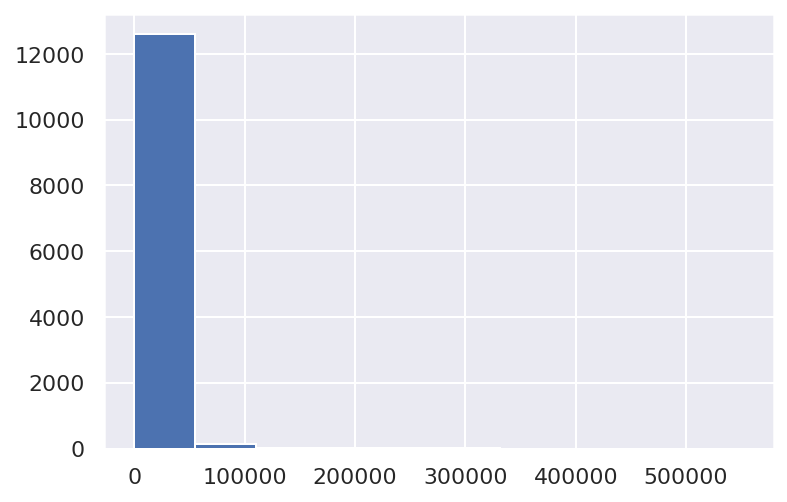

In [174]:
train['XLarge Bags'].hist()

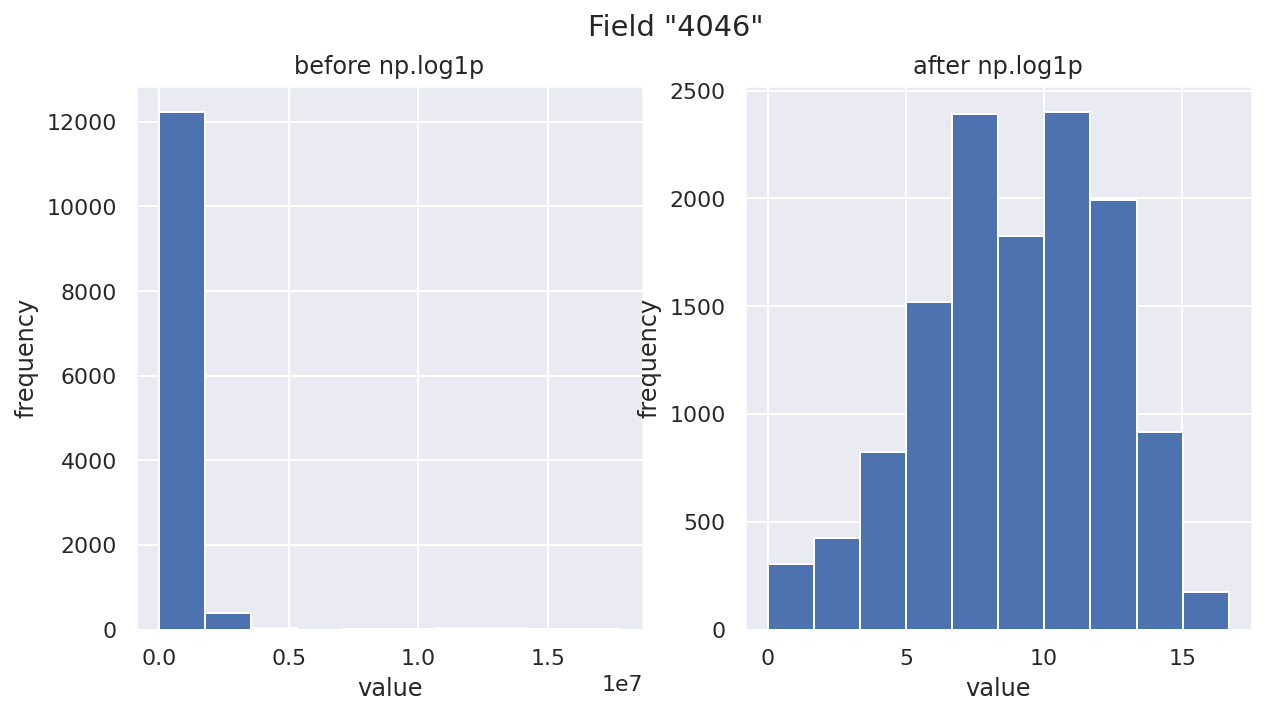

In [175]:
# Let's look at what happens to one of these features, when we apply np.log1p visually.

# Choose a field
field = "4046"

# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Create a histogram on the "ax_before" subplot
train[field].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
train[field].apply(np.log1p).hist(ax=ax_after)

# Formatting of titles etc. for each subplot
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));

> ## Perform the Skew Transformation

In [176]:
skew_cols.index.values

array(['XLarge Bags', '4770', 'Large Bags', 'Total Bags', 'Small Bags',
       '4225', 'Total Volume', '4046'], dtype=object)

In [177]:
# Mute the setting wtih a copy warnings
pd.options.mode.chained_assignment = None

for col in skew_cols.index.tolist():
    if col == '4046':
        continue
    train[col] = train[col].apply(np.log1p)
    test[col] = np.log1p(test[col]) # Alternately

In [178]:
train.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year,type_organic,region_Atlanta,region_BaltimoreWashington,region_Boise,region_Boston,region_BuffaloRochester,region_California,region_Charlotte,region_Chicago,region_CincinnatiDayton,region_Columbus,region_DallasFtWorth,region_Denver,region_Detroit,region_GrandRapids,region_GreatLakes,region_HarrisburgScranton,region_HartfordSpringfield,region_Houston,region_Indianapolis,region_Jacksonville,region_LasVegas,region_LosAngeles,region_Louisville,region_MiamiFtLauderdale,region_Midsouth,region_Nashville,region_NewOrleansMobile,region_NewYork,region_Northeast,region_NorthernNewEngland,region_Orlando,region_Philadelphia,region_PhoenixTucson,region_Pittsburgh,region_Plains,region_Portland,region_RaleighGreensboro,region_RichmondNorfolk,region_Roanoke,region_Sacramento,region_SanDiego,region_SanFrancisco,region_Seattle,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico,season_spring,season_summer,season_winter
8704,0.95,14.090372,548774.22,12.586434,8.710674,13.058243,12.781490,11.637756,4.352469,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5271,1.14,11.337791,24615.83,9.694965,7.750296,10.615522,10.615464,0.000000,1.217876,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
7654,1.17,12.498024,89083.09,11.287354,7.513082,11.483379,11.413782,7.922388,8.235080,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2417,0.99,15.273028,2713600.49,13.291735,11.483627,13.701546,13.339773,12.509166,4.037774,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
11906,1.58,9.533706,6430.36,8.366603,0.000000,8.035068,7.917718,5.837293,0.000000,2015,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


> ## Extracting the Dependent and Independent Features

In [179]:
feature_cols = [x for x in train.columns if x != 'AveragePrice']

X_train = train[feature_cols]
y_train = train[['AveragePrice']]

X_test = test[feature_cols]
y_test = test[['AveragePrice']]

In [180]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12774, 66), (5475, 66), (12774, 1), (5475, 1))

# Data Standardization
Standardizing data refers to transforming each variable so that it more closely follows a standard normal distribution, with mean 0 and standard deviation 1.

> The `StandardScaler` object in SciKit Learn can do this.

In [207]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

> ### Write a function `rmse` that takes in truth and prediction values and returns the root-mean-squared error. Use sklearn's `mean_squared_error`.

In [181]:
from sklearn.metrics import mean_squared_error

def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

> # Linear Regression Model


*   Fit a basic linear regression model
*   Print the root-mean-squared error for this model
*   Plot the predicted vs actual sale price based on the model.





In [183]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg = lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

lin_reg_rmse = rmse(y_test, y_pred)

print(lin_reg_rmse)

0.20682462229529655


> ### With Scaled Features

In [209]:
line_reg_s = lin_reg.fit(X_train_s, y_train)
y_pred_s = lin_reg.predict(X_test_s)

lin_reg_rmse_s = rmse(y_test, y_pred_s)

print(lin_reg_rmse_s)

0.2068246223095483


> ## Let's plot the Linear Regression results

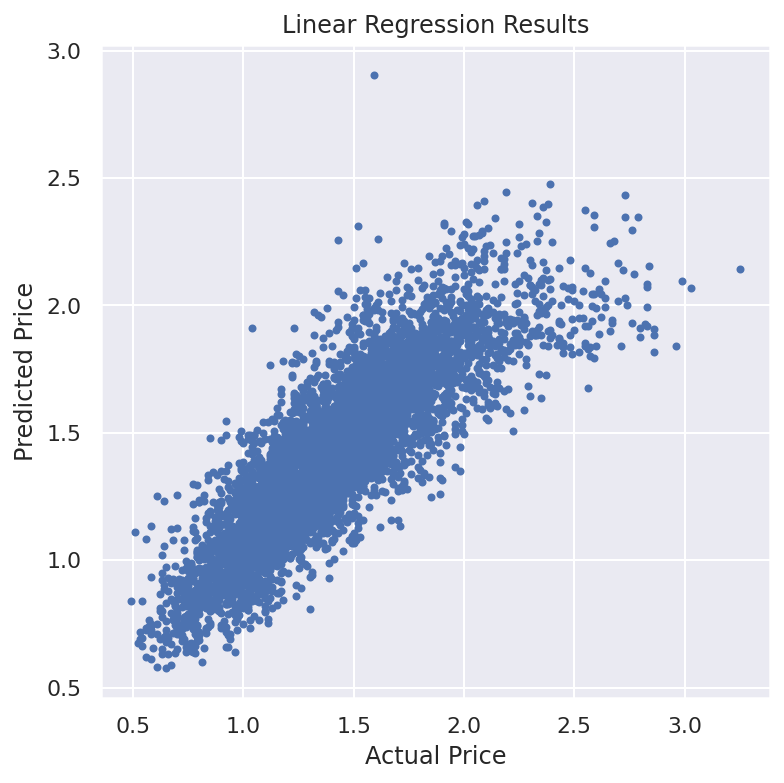

In [210]:
f = plt.figure(figsize = (6, 6))
ax = plt.axes()

ax.plot(y_test, y_pred_s, marker = 'o', ls = '', ms = 3.0)

# lim = (0, y_test.max())

ax.set(xlabel = 'Actual Price',
       ylabel = 'Predicted Price',
       # xlim = lim, 
       # ylim = lim,
       title = 'Linear Regression Results');

> # Ridge Regression
Ridge regression uses L2 normalization to reduce the magnitude of the coefficients. This can be helpful in situations where there is high variance. The regularization functions in Scikit-learn each contain versions that have cross-validation built in.

> * Fit a regular (non-cross validated) Ridge model to a range of 
α values and plot the RMSE using the cross validated error function you created above.
* Use [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80] as the range of alphas.
* Then repeat the fitting of the Ridge models using the range of 
α values from the prior section. Compare the results.

In [ ]:
from sklearn.linear_model import RidgeCV

alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

ridgeCV = RidgeCV(alphas = alphas, cv = 4)
ridgeCV.fit(X_train, y_train)
y_pred_rcv = ridgeCV.predict(X_test)
ridgeCV_rmse = rmse(y_test, y_pred_rcv)

> ## With Scaled Features

In [211]:
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

ridgeCV = RidgeCV(alphas = alphas, cv = 4)
ridgeCV.fit(X_train_s, y_train)
y_pred_rcv_s = ridgeCV.predict(X_test_s)
ridgeCV_rmse_s = rmse(y_test, y_pred_rcv_s)

In [213]:
print(ridgeCV.alpha_, ridgeCV_rmse)
print(ridgeCV.alpha_, ridgeCV_rmse_s)

0.005 0.20682442456113792
0.005 0.2068245904947433


> # Lasso & Elastic Net Regression Models
Much like the RidgeCV function, there is also a LassoCV function that uses an L1 regularization function and cross-validation. L1 regularization will selectively shrink some coefficients, effectively performing feature elimination.

> The LassoCV function does not allow the scoring function to be set. However, the custom error function (rmse) created above can be used to evaluate the error on the final model.

> Similarly, there is also an elastic net function with cross validation, ElasticNetCV, which is a combination of L2 and L1 regularization.
* Fit a Lasso model using cross validation and determine the optimum value for 
α and the RMSE using the function created above. Note that the magnitude of 
α may be different from the Ridge model.
* Repeat this with the Elastic net model.
* Compare the results via table and/or plot.

> Use the following alphas: [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 20, 50, 80, 100, 120, 140]

In [201]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([0.005, 0.05, 0.1, 0.3, 1, 3, 5, 20, 50, 80, 100, 120, 140])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=4).fit(X_train, y_train)

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

print(lassoCV.alpha_, lassoCV_rmse)  # Lasso is slower

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.005 0.2668435134752518


In [214]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([0.005, 0.05, 0.1, 0.3, 1, 3, 5, 20, 50, 80, 100, 120, 140])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=4).fit(X_train_s, y_train)

lassoCV_rmse_s = rmse(y_test, lassoCV.predict(X_test_s))

print(lassoCV.alpha_, lassoCV_rmse_s)  # Lasso is slower

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.005 0.22492283373271824


> ### We can determine how many of these features ramain non-zero

In [202]:
print('Of {} coefficients, {} are non-zero with Lasso.'.format(len(lassoCV.coef_), 
                                                               len(lassoCV.coef_.nonzero()[0])))

Of 66 coefficients, 14 are non-zero with Lasso.


> ### Now try the elastic net, with the same alphas as in Lasso, and l1_ratios between 0.1 and 0.9

In [203]:
from sklearn.linear_model import ElasticNetCV

l1_ratios = np.linspace(0.1, 0.9, 9)

elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e4).fit(X_train, y_train)
elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test))

print(elasticNetCV.alpha_, elasticNetCV.l1_ratio_, elasticNetCV_rmse)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.005 0.1 0.22706429407428722


In [215]:
from sklearn.linear_model import ElasticNetCV

l1_ratios = np.linspace(0.1, 0.9, 9)

elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e4).fit(X_train_s, y_train)
elasticNetCV_rmse_s = rmse(y_test, elasticNetCV.predict(X_test_s))

print(elasticNetCV.alpha_, elasticNetCV.l1_ratio_, elasticNetCV_rmse_s)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.005 0.1 0.2103760162596727


> ### Comparing the RMSE calculation from all models is easiest in a table.


In [205]:
rmse_vals = [lin_reg_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]

labels = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']

rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

,RMSE
Linear,0.206825
Ridge,0.206824
Lasso,0.266844
ElasticNet,0.227064


In [216]:
rmse_vals = [lin_reg_rmse_s, ridgeCV_rmse_s, lassoCV_rmse_s, elasticNetCV_rmse_s]

labels = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']

rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

,RMSE
Linear,0.206825
Ridge,0.206825
Lasso,0.224923
ElasticNet,0.210376


> ## We can also make a plot of actual vs predicted Avocado prices as before.

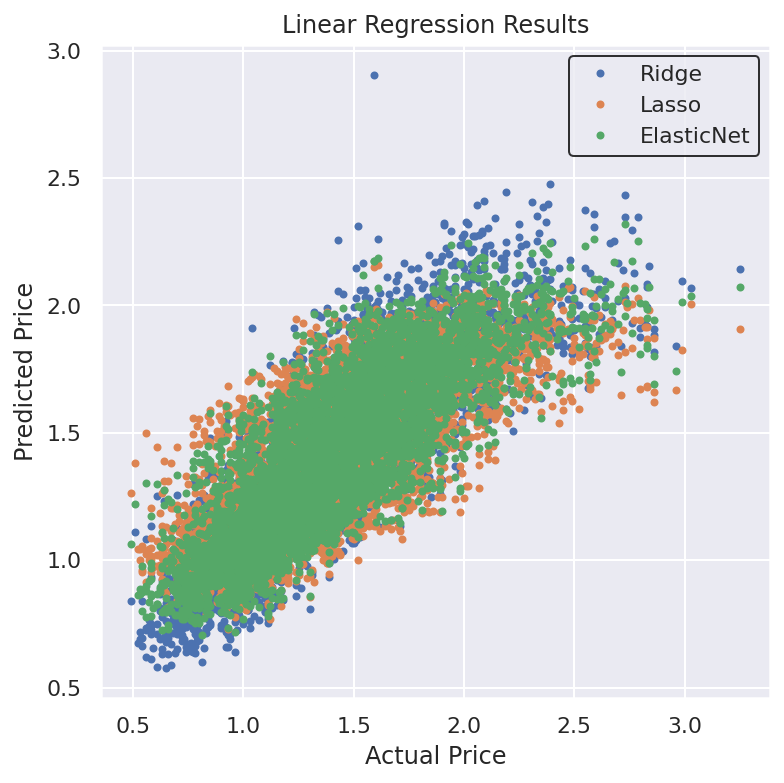

In [206]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

labels = ['Ridge', 'Lasso', 'ElasticNet']

models = [ridgeCV, lassoCV, elasticNetCV]

for mod, lab in zip(models, labels):
    ax.plot(y_test, mod.predict(X_test), 
             marker='o', ls='', ms=3.0, label=lab)


leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       title='Linear Regression Results');

> # Conclusion
It doesn't matter whether you scale features before or afterwards, in terms of the raw predictions, for Linear Regression. However, it matters for other algorithms like Ridge, Lasso, and Elastic Net models.